# Training Model

In [1]:
from osgeo import gdal, gdal_array
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
import matplotlib.cm as colormap
import matplotlib.pyplot as pyplot
pyplot.rcParams["font.family"] = "Times New Roman"
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
#read dataset for creating model
stacked_training = gdal.Open('training_data/stacked_indicies_kampar.tif', gdal.GA_ReadOnly)
smi_training = gdal.Open('training_data/smi_training_1.tif', gdal.GA_ReadOnly)

In [4]:
#convert dataset to array then create features and labels for training purposes
stacked_zeros = np.zeros((stacked_training.RasterYSize, stacked_training.RasterXSize, stacked_training.RasterCount),
                            gdal_array.GDALTypeCodeToNumericTypeCode(stacked_training.GetRasterBand(1).DataType))
for a in range(stacked_zeros.shape[2]):
    stacked_zeros[:, :, a] = stacked_training.GetRasterBand(a + 1).ReadAsArray()
smi = smi_training.GetRasterBand(1).ReadAsArray().astype(np.float32)
smi_masked = np.ma.masked_where(smi == 0, smi)
x = stacked_zeros[smi > 0, :] #feature
y = smi[smi > 0] #label
print('X shape {x} and Y shape {y}'.format(x = x.shape, y = y.shape))

X shape (176810, 15) and Y shape (176810,)


In [5]:
#split dataset to training and test data by 75% and 25%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
print('Training features shape :', x_train.shape)
print('Training labels shape :', y_train.shape)
print('Testing features shape', x_test.shape)
print('Testing labels shape:', y_test.shape)

Training features shape : (132607, 15)
Training labels shape : (132607,)
Testing features shape (44203, 15)
Testing labels shape: (44203,)


In [6]:
#train our model by using training data and predict it
rf_reg = RandomForestRegressor(bootstrap= True, n_estimators = 200, max_depth = None, 
                              max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, random_state = 42)
rf_reg.fit(x_train, y_train)
print('Training model ...')
train_prediction = rf_reg.predict(x_test)
print('predict training area')

Training model ...
predict training area


In [7]:
#calculate statistics of model result
err = abs(train_prediction - y_test)
print('MAE:', round(np.mean(err), 2), 'degrees.')
mape = 100 * (err / y_test)
acc = 100 - np.mean(mape)
print('Accuracy', round(acc, 2), '%.')
rsq = r2_score(y_test, train_prediction)
print('Our R Squared score is {r}'.format(r = rsq))

MAE: 0.08 degrees.
Accuracy 83.36 %.
Our R Squared score is 0.5526341224757939


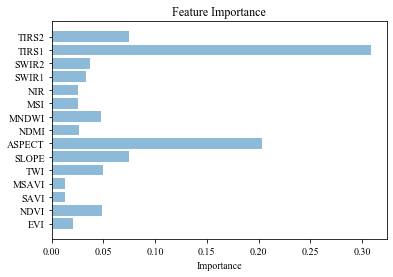

In [8]:
# feature importance
features_raster = ["EVI", "NDVI", "SAVI", "MSAVI", "TWI", "SLOPE", "ASPECT", 
                    "NDMI", "MNDWI", "MSI", "NIR", "SWIR1", "SWIR2", "TIRS1", "TIRS2"]
imp = rf_reg.feature_importances_
ftr = np.arange(len(features_raster))
pyplot.barh(ftr, imp, align="center", alpha=0.5)
pyplot.yticks(ftr, features_raster)
pyplot.xlabel('Importance')
pyplot.title('Feature Importance')
pyplot.savefig('results/feature_importance_kampar.png', dpi = 192)
pyplot.show()

Reshaped verification image from (304, 586, 15) to (178144, 15)


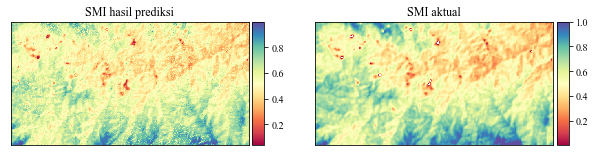

Success training data


In [10]:
#predict whole training area
new_training_shape = (stacked_zeros.shape[0] * stacked_zeros.shape[1], stacked_zeros.shape[2])
verification_image = stacked_zeros[:, :, :15].reshape(new_training_shape)
print('Reshaped verification image from {o} to {n}'.format(o = stacked_zeros.shape, n = verification_image.shape))
verification_prediction =  rf_reg.predict(verification_image)
final_verification_prediction = verification_prediction.reshape(stacked_zeros[:, :, 0].shape)

#display the result
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize = (10,3))
ax1.set_facecolor('#ffffff')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
img_smi_train = ax1.imshow(final_verification_prediction, cmap=colormap.get_cmap('Spectral'))
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_train, cax = cax1)
ax1.set_title('SMI hasil prediksi')

ax2.set_facecolor('#ffffff')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
img_smi = ax2.imshow(smi_masked, cmap=colormap.get_cmap('Spectral'))
ax2.set_title('SMI aktual')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi, cax = cax2)
pyplot.savefig('results/training_result_image.png', dpi = 192)
pyplot.show()
print('Success training data')

In [9]:
def save_raster(out_name, ras_shape_1, ras_shape_0, ras, ras_geo_transform, ras_projection):
    driver = gdal.GetDriverByName("GTiff")
    src = driver.Create(out_name, ras_shape_1, ras_shape_0, 1, gdal.GDT_Float32)
    band = src.GetRasterBand(1)
    band.WriteArray(ras)
    band.SetNoDataValue(0)
    src.SetGeoTransform(ras_geo_transform)
    src.SetProjection(ras_projection)
    del band
    del src
    success = print('Predicted result saved')
    return success

In [10]:
#save the training result to raster (.tiff)
ras_geo_transform = smi_training.GetGeoTransform()
ras_projection = smi_training.GetProjection()
namefile = 'results/predicted_smi_training.tif'
ras_shape_1 = final_verification_prediction.shape[1]
ras_shape_0 = final_verification_prediction.shape[0]
ras = final_verification_prediction

save_raster(namefile, ras_shape_1, ras_shape_0, ras, ras_geo_transform, ras_projection)

Predicted result saved


# Testing model to predict study area

In [11]:
#read study area raster dataset
ts_stacked = gdal.Open('test_data/stacked_indicies_kampar_testing.tif', gdal.GA_ReadOnly) #dir can be changed
ts_smi = gdal.Open('test_data/smi_kampar_testing.tif', gdal.GA_ReadOnly) #dir can be changed

In [12]:
#convert dataset to array then create features and labels for testing purposes
study_area_zeros = np.zeros((ts_stacked.RasterYSize, ts_stacked.RasterXSize, ts_stacked.RasterCount),
                                gdal_array.GDALTypeCodeToNumericTypeCode(ts_stacked.GetRasterBand(1).DataType))
for b in range(study_area_zeros.shape[2]):
    study_area_zeros[:, :, b] = ts_stacked.GetRasterBand(b + 1).ReadAsArray()
smi_study_area = ts_smi.GetRasterBand(1).ReadAsArray().astype(np.float32)
smi_study_area_masked = np.ma.masked_where(smi_study_area == 0, smi_study_area)
x_study = study_area_zeros[smi_study_area > 0, :] #feature
y_study = smi_study_area[smi_study_area > 0] #label
print('X shape {x} and Y shape {y}'.format(x = x_study.shape, y = y_study.shape))

X shape (11095048, 15) and Y shape (11095048,)


In [13]:
#split our data to train and test data by 75% and 25%
x_train_study, x_test_study, y_train_study, y_test_study = train_test_split(x_study, y_study, test_size = 0.25, random_state = 42)
print('Training features shape :', x_train_study.shape)
print('Training labels shape :', y_train_study.shape)
print('Testing features shape', x_test_study.shape)
print('Testing labels shape:', y_test_study.shape)

Training features shape : (8321286, 15)
Training labels shape : (8321286,)
Testing features shape (2773762, 15)
Testing labels shape: (2773762,)


In [14]:
#predict study area
new_test_shape = (study_area_zeros.shape[0] * study_area_zeros.shape[1], study_area_zeros.shape[2])
study_area_image = study_area_zeros[:, :, :15].reshape(new_test_shape)
print('Reshaped study area image from {o} to {n}'.format(o = study_area_zeros.shape, n = study_area_image.shape))
study_area_prediction = rf_reg.predict(study_area_image)
final_study_area_prediction = study_area_prediction.reshape(study_area_zeros[:, :, 0].shape)
masked_study_area_prediction = np.ma.masked_where(final_study_area_prediction == 0, final_study_area_prediction)

Reshaped study area image from (5094, 4479, 15) to (22816026, 15)


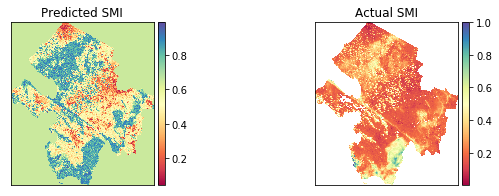

Success predict our study area


In [15]:
#display testing result
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize = (10,3))
ax1.set_facecolor('#ffffff')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
img_smi_prediction = ax1.imshow(masked_study_area_prediction, cmap = colormap.get_cmap('Spectral'))
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_prediction, cax = cax1)
ax1.set_title('Predicted SMI')

ax2.set_facecolor('#ffffff')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
img_smi_actual = ax2.imshow(smi_study_area_masked, cmap = colormap.get_cmap('Spectral'))
ax2.set_title('Actual SMI')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_smi_actual, cax = cax2)
pyplot.savefig('results/testing_result_image.png', dpi = 192)
pyplot.show()

print('Success predict our study area')

In [16]:
#calculate statistics of testing results
test_prediction = rf_reg.predict(x_test_study)
err_test = abs(test_prediction - y_test_study)
print('MAE:', round(np.mean(err_test), 2), 'degrees.')
mape_test = 100 * (err_test / y_test_study)
acc_test = 100 - np.mean(mape_test)
print('Accuracy', round(acc_test, 2), '%.')
rsq_test = r2_score(y_test_study, test_prediction)
print('Our R Squared score for study area is {r}'.format(r = rsq_test))

MAE: 0.34 degrees.
Accuracy -46.09 %.
Our R Squared score for study area is -7.462116662981835


In [17]:
#save the testing result to raster (.tiff)

ras_geo_transform_testing = ts_smi.GetGeoTransform()
ras_projection_testing = ts_smi.GetProjection()
namefile_testing = 'results/predicted_smi_testing.tif'
ras_shape_1_testing = masked_study_area_prediction.shape[1]
ras_shape_0_testing = masked_study_area_prediction.shape[0]
ras_testing = final_study_area_prediction

save_raster(namefile_testing, ras_shape_1_testing, ras_shape_0_testing, ras_testing, ras_geo_transform_testing, ras_projection_testing)

Predicted result saved
